In [1]:
import os
import sys
from pathlib import Path

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd

from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Project level imports
sys.path.insert(0, '../lib')
from ncbi_remap.notebook import Nb
from ncbi_remap.plotting import make_figs

%matplotlib widget

In [2]:
# Setup notebook
nbconfig = Nb.setup_notebook()

Please check output/fbgn2chrom.tsv. If it does not exist, run bin/fbgn2chrom.py
last updated: 2018-09-26 
Git hash: 3e6018d790e56d8ccd70647a7eccff8c120a8e6d


In [3]:
# Connect to data store
store = pd.HDFStore('../output/sra.h5', mode='r')

In [4]:
from pymongo import MongoClient
try:
    with open('../output/.mongodb_host', 'r') as fh:
        host = fh.read().strip()
except FileNotFoundError:
    host = 'localhost'

mongoClient = MongoClient(host=host, port=27017)
db = mongoClient['sra']
ncbi = db['ncbi']

In [5]:
complete = store['aln/complete']

In [6]:
labels = pd.DataFrame(list(ncbi.aggregate([
    {'$unwind': {'path': '$runs'}},
    {
        '$project': {
            '_id': 0,
            'srx': '$srx',
            'srr': '$runs.srr',
            'library_strategy': '$sra.experiment.library_strategy'
        }
    },
])))

labels.set_index(['srx', 'srr'], inplace=True)
labels = labels.library_strategy

complete_idx = complete.set_index(['srx', 'srr']).index
labels = labels.reindex(complete_idx)

In [7]:
labels.value_counts().map(lambda x: f'{x:,}')

RNA-Seq                   18,426
OTHER                      4,701
EST                        4,699
ChIP-Seq                   3,345
WGS                        2,244
miRNA-Seq                    131
MNase-Seq                    121
Targeted-Capture              96
AMPLICON                      86
ncRNA-Seq                     69
RIP-Seq                       64
FAIRE-seq                     25
DNase-Hypersensitivity        10
POOLCLONE                      8
FL-cDNA                        7
CLONEEND                       7
MeDIP-Seq                      6
WGA                            6
Bisulfite-Seq                  5
CLONE                          1
Name: library_strategy, dtype: object

In [8]:
labels_small = labels[labels.isin(['RNA-Seq', 'ChIP-Seq', 'WGS', 'EST'])]
labels_small.index = labels_small.index.droplevel(-1)
labels_small = labels_small.groupby('srx').first()

In [9]:
genic = pd.read_parquet('../output/aln-downstream-wf/aggregate_genic_counts.parquet').reindex(labels_small.index)['count']
genic.name = 'genic'

intergenic = pd.read_parquet('../output/aln-downstream-wf/aggregate_intergenic_counts.parquet').reindex(labels_small.index)['count']
intergenic.name = 'intergenic'

juncs = pd.read_parquet('../output/aln-downstream-wf/aggregate_junction_counts.parquet').reindex(labels_small.index)['count']
juncs.name = 'junctions'

In [10]:
dat = pd.concat([genic, intergenic, juncs], axis=1)
total = dat.sum(axis=1)

In [11]:
pct_reads = dat.div(total, axis=0) * 100
pct_reads = pct_reads.join(labels)

In [12]:
dat2 = np.log1p(dat).join(labels)

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [14]:
scaler = StandardScaler()
pct_scaled = scaler.fit_transform(pct_reads.iloc[:, :3])

In [15]:
pca = PCA(n_components=3)

In [16]:
pct_pca = pca.fit_transform(pct_scaled)

In [19]:
df_pca = pd.DataFrame(pct_pca, columns=['PC1', 'PC2', 'PC3'], index=pct_reads.index).join(labels)

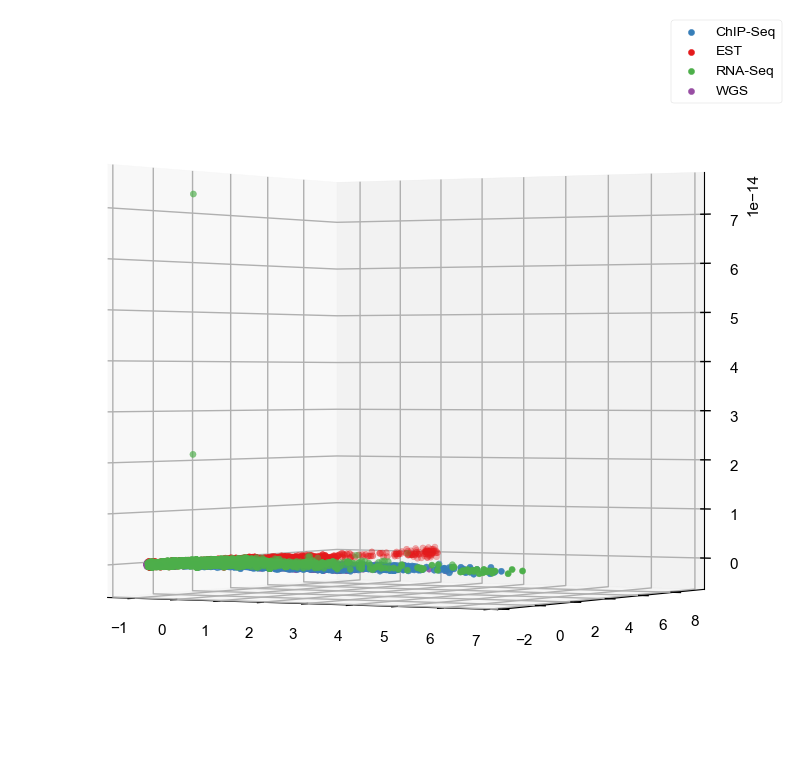

In [23]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(10, 20)

for g, df in df_pca.groupby("library_strategy"):
    ax.scatter(df.PC1, df.PC2, df.PC3, label=g)
    
plt.legend()
ax.view_init(0)